In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!pip install contractions

In [3]:
!pip install nltk

In [4]:
# Problem with gensim 3.8.2
!pip install gensim==3.8.1

     |████████████████████████████████| 24.2 MB 9.0 MB/s eta 0:00:01     |████████████████▊               | 12.6 MB 9.0 MB/s eta 0:00:02
     |████████████████████████████████| 105 kB 60.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 33.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.1 MB 42.8 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 57.0 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-1.11.1-py3-none-any.whl size=95255 sha256=602377d3961b1806821712aea7bc089080c727fc95f355af93f263d9d4d581a3
  Stored in directory: /root/.cache/pip/wheels/89/6b/f0/391fb74c038a4b87d4ac6ef4cd4c96ea820ec39b60f78d03a1
Successfully built smart-open


In [4]:
import contractions

In [5]:
DATA_DIRECTORY = 'datasets'

In [6]:
DUMP_FILE = "combined_data.p"

# Load the dataset

In [22]:
data = pickle.load(open(os.path.join(DATA_DIRECTORY, DUMP_FILE), "rb"))

In [23]:
data.head()

,class,tweet,id
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,3
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,4


In [24]:
data.loc[201]

class                                                    1
tweet    "@Nicholas_ted33: Kobe stay talking trash. But...
id                                                     203
Name: 201, dtype: object

# Preprocess the text


In [7]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

In [9]:
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, stem_text, strip_short, strip_non_alphanum, strip_numeric

#### Choosing to tokenize first or links and mentions will pollute the data when split out
Unfortunately, this process will be slower since every token has to be checked instead of whole tweet

In [10]:
# Create a partial of strip_short to set the min length. Default is 3
from functools import partial
strip_short2 = partial(strip_short, minsize=2)

In [11]:
uri_pattern = re.compile(r'[A-z]://.*')
def remove_link(token):
    """
    If the token is a uri then simply don't return anything back
    """    
    if not re.match(uri_pattern, token):
        return token
    
    return

In [12]:
def remove_mention(token):
    """
    If the token starts with an @ then return none otherwise return the token
    """
    if not token.startswith('@'):
        return token
    
    return

In [13]:
def remove_punc(token):
    """
    Removes tokens that are only punctuation 
    """
    token = re.sub(r'\W', "", token)
    return token if token else None
    

In [14]:
def remove_numeric(token):
    """
    Remove numeric only tokens.  They don't add value to this classification
    """
    return token if not token.isnumeric() else None

In [15]:
def remove_rt(token):
    """
    Most common word in the vocabulary is RT remove this to clean up
    """
    token = token.replace("rt", "")
    return token if token else None

In [16]:
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [17]:
def preprocess_tweet(tweet, global_process, token_tweet):
    """
    Work through the tweet and do the following:
    * Tokenize with a tweet specific tokenizer
    * take a pass through all the tokens running tests on each one
    """
    
        
    # Process global things done on entire tweet
    for func in globa_process_list:
        tweet = func(tweet)
    
    # Now tokenize
    tokens = tweet_tokenizer.tokenize(tweet)

    # Clean tokens
    processed_tokens = []
    for token in tokens:
        for func in process_list:
            token = func(token)
            if not token:
                break
        else:
            processed_tokens.append(token)
    
    return processed_tokens
    

In [18]:
globa_process_list = [str.lower, contractions.fix, remove_accented_chars]
process_list = [str.lower, str.strip, remove_link, remove_mention, remove_punc, 
                remove_rt, strip_non_alphanum, strip_numeric, strip_short2, remove_stopwords, stem_text]

In [20]:
preprocess_tweet("!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...#buildthewall", globa_process_list, process_list)

['woman', 'complain', 'clean', 'hous', 'man', 'trash', 'buildthewal']

In [21]:
tokenized_tweets = [preprocess_tweet(pt, globa_process_list, process_list) for pt in data['tweet']]

In [22]:
tokenized_tweets[0]

['woman', 'complain', 'clean', 'hous', 'man', 'trash']

#### Pickle the tokenized tweets

In [25]:
TOKENIZED_DUMP = "tokenized_tweets.p"

In [26]:
pickle.dump(tokenized_tweets, open(os.path.join(DATA_DIRECTORY, TOKENIZED_DUMP), "wb"))

### Now we are going to glue them all back together to be able to create BOW and TDIDF matrices


In [23]:
corpus = [" ".join(tweet) for tweet in tokenized_tweets]

In [24]:
corpus[0]

'woman complain clean hous man trash'

#### Pickle the corpus


In [29]:
PREPROCESSED_CORPUS_DUMP = "preprocessed_corpus.p"
pickle.dump(corpus, open(os.path.join(DATA_DIRECTORY, PREPROCESSED_CORPUS_DUMP), "wb"))

### Finding a vocabulary to use
Ideal is supposed to be around 10000

In [25]:
from nltk.lm import Vocabulary
import itertools

In [26]:
vocab = Vocabulary(itertools.chain(*tokenized_tweets))

In [27]:
word_list = []
freq_list = []
for word, freq in vocab.counts.most_common():
    word_list.append(word)
    freq_list.append(freq)

In [40]:
freq_list[12000]

2

In [34]:
#To graph this we need a subset of each or the graph will explode
x_axis = word_list[0:1000:50]
y_axis = freq_list[0:1000:50]

In [35]:
len(x_axis), len(y_axis)

(20, 20)

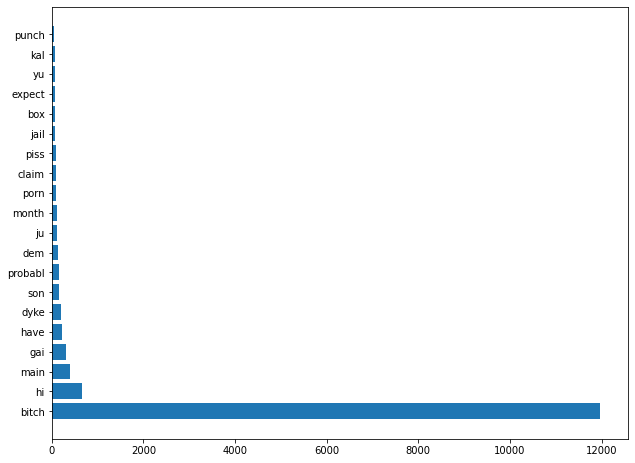

In [36]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.barh(x_axis, y_axis)
plt.show()

#### Findings

The frequency drops of fast. By 750 the frequency is < 100 and by 5000 it is < 10. We will probably cut of at frequency 5 just to have something useful.

In [47]:
vocab_final = Vocabulary(itertools.chain(*tokenized_tweets), unk_cutoff=5)

In [42]:
vocab_small = Vocabulary(itertools.chain(*tokenized_tweets), unk_cutoff=10)

In [44]:
vocab_large = Vocabulary(itertools.chain(*tokenized_tweets), unk_cutoff=3)

#### Pickle the vocab


In [53]:
VOCAB_DUMP = "vocab.p"

In [54]:
pickle.dump(vocab_final, open(os.path.join(DATA_DIRECTORY, VOCAB_DUMP), "wb"))

In [55]:
VOCAB_DUMP_SM = "vocab_sm.p"

In [56]:
pickle.dump(vocab_small, open(os.path.join(DATA_DIRECTORY, VOCAB_DUMP_SM), "wb"))

In [57]:
VOCAB_DUMP_LG = "vocab_lg.p"

In [58]:
pickle.dump(vocab_large, open(os.path.join(DATA_DIRECTORY, VOCAB_DUMP_LG), "wb"))

# word2vec experiments

In [3]:
from gensim.models import Word2Vec

In [37]:

model_w2v = Word2Vec(tokenized_tweets, size=200)

In [38]:
import gensim.downloader as api

In [39]:
model_w2v.intersect_word2vec_format?

In [41]:
model_w2v.intersect_word2vec_format('/root/gensim-data/glove-twitter-200/glove-twitter-200.gz',
                                lockf=1.0,# Allow updates to training
                                binary=False)

In [42]:
model_w2v.train(tokenized_tweets,total_examples=model_w2v.corpus_count, epochs=10)

(2736624, 3553440)

In [50]:
model_w2v.corpus_count

44623

In [64]:
'hous' in model_w2v.wv

True

In [10]:
MODEL_DUMP = "w2v.model"

In [67]:
model_w2v.save(os.path.join(DATA_DIRECTORY, MODEL_DUMP))

# Deep Learning

Setup a different set of tasks for deep learning since it needs less preprocessing and we want to get the benefit of evaluation over the entire tweet

In [20]:
globa_process_list = [str.lower, contractions.fix, remove_accented_chars]
process_list = [str.lower, str.strip, remove_link, remove_mention, remove_punc, 
                remove_rt, strip_non_alphanum, strip_numeric, stem_text]

The main difference is pulling out stop words and short words

In [26]:
dl_tokenized = [preprocess_tweet(pt, globa_process_list, process_list) for pt in data['tweet']]

In [33]:
dl_tokenized[1110]

['did', 'i', 'just', 'sta', 'cry', 'bitch']

In [34]:
data.iloc[1110].tweet

'&#8220;@AriaunaDaVon: Did I just start crying? &#128553;&#128557;&#128514;&#8221; bitch &#128514;&#128514;&#128514;'

In [35]:
dl_corpus = [" ".join(tweet) for tweet in dl_tokenized]

In [36]:
dl_corpus[1110]

'did i just sta cry bitch'

#### Dump tokens

In [37]:
DL_TOKENIZED_DUMP = "dl_tokenized_tweets.p"

In [38]:
pickle.dump(dl_tokenized, open(os.path.join(DATA_DIRECTORY, DL_TOKENIZED_DUMP), "wb"))

#### Dump Corpus

In [39]:
DL_PREPROCESSED_CORPUS_DUMP = "dl_preprocessed_corpus.p"
pickle.dump(dl_corpus, open(os.path.join(DATA_DIRECTORY, DL_PREPROCESSED_CORPUS_DUMP), "wb"))